rename this file from AE_style_transfer_2 to cinn_style_transfer_inference

In [52]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os

In [53]:
from autoencoder import AEStyleTransfer

In [54]:
# Get the current working directory
current_directory = os.getcwd()

In [55]:
device='cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [56]:
# Define the relative path to the dataset directory
dataset_directory = os.path.join(current_directory, 'datasets')

# Define the filename
filename = 'autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth'

# Combine the directory path and filename to obtain the full path to the file
PATH_PARAMS_AE_PRETRAINED  = os.path.join(dataset_directory, filename)

In [57]:
# Load the pretrained model
pretrained_model_list = torch.load(PATH_PARAMS_AE_PRETRAINED,map_location=torch.device('cpu'))
# this is because the AE was originally trained on GPUs.

# instantiate the model
ae_pretrained= AEStyleTransfer(dropout_prob=0.01)

ae_pretrained.load_state_dict(pretrained_model_list)

<All keys matched successfully>

### Load Encodings

In [58]:
dataset_directory

'd:\\Desktop\\master_scientific_computing\\first_semester\\GNN\\project_repository\\GNN-exercises\\Project\\datasets'

In [59]:
PATH_ENCODINGS_TRAIN= os.path.join(dataset_directory, "encoded_images_ST_train_set.pt")
PATH_COLORED_MNIST_TEST= os.path.join(dataset_directory, "encoded_images_ST_test_set.pt")

In [60]:
encoded_image_train_set = torch.load(PATH_ENCODINGS_TRAIN)

encoded_image_test_set=  torch.load(PATH_COLORED_MNIST_TEST)

In [61]:
encoded_image_train_set.size(), encoded_image_test_set.size()

(torch.Size([60000, 24]), torch.Size([20000, 24]))

Note that first half of encodings in the train and test set above are un-colored and remaining half are colored

In [62]:
def create_encodings_labels(data_in):
    len_data=data_in.size()[0]
    labels= torch.concatenate((torch.zeros(len_data//2), torch.ones(len_data//2)))
    labels= labels.unsqueeze(1)
    return labels

In [63]:
labels_train=create_encodings_labels(encoded_image_train_set)
labels_test= create_encodings_labels(encoded_image_test_set)

### Create the dataloaders

In [64]:
from datasets import CustomEncodedStyleTransfer

In [65]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

train_dataset = CustomEncodedStyleTransfer(encoded_image_train_set, labels_train)
test_dataset = CustomEncodedStyleTransfer(encoded_image_test_set, labels_test)

# Calculate the number of samples for training and validation
total_samples = len(train_dataset)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

# Split the train_dataset into train and val datasets with a fixed random seed
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))

# Define batch size
batch_size = 32

# Create data loaders for train, val, and test sets with shuffling and fixed random seed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          worker_init_fn=np.random.seed)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Let's check the performance of the trained cinn on test dataloader

In [68]:
from cINN import ConditionalRealNVP

Load the pre-trained CINN model

In [69]:
### instantiate the CINN model
### TO DO: add code for loading the pre-trained model
model_cinn_style_transfer =  ConditionalRealNVP(input_size=24, hidden_size=2, n_blocks=1, condition_size=1)

Checking style transfer on test dataset

In [73]:
def style_transfer_after_training(model_cinn, encoded_source_image, source_style_label,
                                  label_target_style, device=device):
    encoded_source_image, source_style_label = encoded_source_image.to(device), source_style_label.to(device)


    # Get the residual
    model_cinn.eval()
    z, _ = model_cinn( encoded_source_image, source_style_label)

    # Define the target style label
    y_label_colored = torch.tensor([label_target_style]).to(device)

    # Transfer the style
    model_cinn.eval()
    x_transfered = model_cinn._inverse(z, y_label_colored)

    return x_transfered

def decode_latent_vec(latent_rep, ae_model):
  ae_model.eval()
  decoded= ae_model.decoder(latent_rep)
  return decoded

def plot_images(image1, image2):
    fig, axes = plt.subplots(1, 2,figsize=(4, 4))
    axes[0].imshow(np.transpose(image1.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[0].set_title('True Image')
    axes[0].axis('off')

    axes[1].imshow(np.transpose(image2.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[1].set_title('Style Transferred')
    axes[1].axis('off')

    plt.show()

In [74]:
i=68
x_uncolored, y_label=encoded_image_test_set[i,:], labels_test[i]
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
x_trans_check= style_transfer_after_training(model_cinn_style_transfer,
                                             x_uncolored, y_label, 1, device=device)

### let's send x through the decoder
decoded_x_style_trans= decode_latent_vec(x_trans_check, ae_pretrained)
decoded_original= decode_latent_vec(x_uncolored, ae_pretrained)

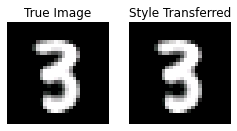

In [75]:
#
plot_images(decoded_original, decoded_x_style_trans)

In [76]:
# Define a function to plot multiple images in a subplot
def plot_images_subplot(images, titles):
    fig, axes = plt.subplots(2, 10, figsize=(12, 4))

    for i, (original, style_transferred) in enumerate(images):
        # Plot original images in the first row
        axes[0, i].imshow(original.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[0, i].set_title(titles[i][0], fontsize=11)
        axes[0, i].axis('off')

        # Plot style transferred images in the second row
        axes[1, i].imshow(style_transferred.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[1, i].set_title(titles[i][1], fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [77]:
# Select 5 random indices from the test set
import random
random_indices = random.sample(range(len(encoded_image_test_set[:9000])), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_uncolored, y_label = encoded_image_test_set[i], labels_test[i]
    x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_uncolored, y_label, label_target_style, device=device)

    decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
    decoded_x_style_trans = decode_latent_vec(x_trans_check, ae_pretrained)

    images_to_plot.append((decoded_original, decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

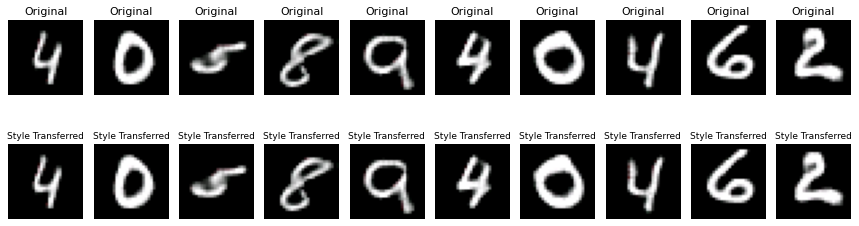

In [78]:
# Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)

### Encoded dataset for style transfer

In [79]:
# from datasets.custom_encoding_style_transfer import MixedMNIST,encodings_inputs_for_style_transfer,CustomEncodedStyleTransfer

# mixed_mnist_data=MixedMNIST(colored_rgb_mnist_dataset=colored_test_images,
#                             pre_trained_ae=ae_pretrained)

# mixed_image_dataset= mixed_mnist_data.mixed_images

# print(mixed_image_dataset.shape)
# print(mixed_mnist_data.mixed_images_labels.shape)

# ### let's create the encodings
# check_encodings= encodings_inputs_for_style_transfer(ae_model=ae_pretrained, data= mixed_image_dataset)

# print(check_encodings.shape)

In [80]:
# import matplotlib.pyplot as plt
# import torch

# # Assuming colored_test_images is your tensor
# first_5_images = mixed_image_dataset[:10]

# # Plot the first 5 images
# fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
# for i in range(10):
#     img = first_5_images[i]
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Image {i+1}')

# plt.show()

In [81]:
# Assuming colored_test_images is your tensor
# first_5_images = mixed_image_dataset[60000:600010]

# # Plot the first 5 images
# fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
# for i in range(10):
#     img = first_5_images[i]
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Image {i+1}')

# plt.show()